## Basic regression: Predict fuel efficiency (https://www.tensorflow.org/tutorials/keras/regression)

In a regression problem, the aim is to predict the output of a continuous value, like a price or a probability. Contrast this with a classification problem, where the aim is to select a class from a list of classes (for example, where a picture contains an apple or an orange, recognizing which fruit is in the picture).

This tutorial uses the classic <a href="https://archive.ics.uci.edu/ml/datasets/auto+mpg">Auto MPG</a> dataset and demonstrates how to build models to predict the fuel efficiency of the late-1970s and early 1980s automobiles. To do this, you will provide the models with a description of many automobiles from that time period. This description includes attributes like cylinders, displacement, horsepower, and weight.

This example uses the Keras API. (Visit the Keras <a href="https://www.tensorflow.org/tutorials/keras">tutorials</a> and <a href="https://www.tensorflow.org/guide/keras">guides</a> to learn more.)

In [1]:
# Use seaborn for pairplot.
!pip install -q seaborn

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [3]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2025-03-21 03:53:03.031858: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742529183.047232     769 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742529183.052136     769 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742529183.062907     769 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742529183.062922     769 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742529183.062923     769 computation_placer.cc:177] computation placer alr

2.19.0


## The Auto MPG dataset

The dataset is available from the <a href="https://archive.ics.uci.edu/ml/">UCI Machine Learning Repository</a>.

### Get the data

First download and import the dataset using pandas:

In [4]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

In [5]:
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


## Clean the data

The dataset contains a few unknown values:

In [6]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [7]:
dataset = dataset.dropna()

The <code>"Origin"</code> column is categorical, not numeric. So the next step is to one-hot encode the values in the column with <a href="https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html">pd.get_dummies</a>.

In [8]:
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

In [9]:
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,False,False,True
394,44.0,4,97.0,52.0,2130.0,24.6,82,True,False,False
395,32.0,4,135.0,84.0,2295.0,11.6,82,False,False,True
396,28.0,4,120.0,79.0,2625.0,18.6,82,False,False,True
397,31.0,4,119.0,82.0,2720.0,19.4,82,False,False,True


## Split the data into training and test sets

Now, split the dataset into a training set and a test set. You will use the test set in the final evaluation of your models.

In [10]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

### Inspect the data

Review the joint distribution of a few pairs of columns from the training set.

The top row suggests that the fuel efficiency (MPG) is a function of all the other parameters. The other rows indicate they are functions of each other.

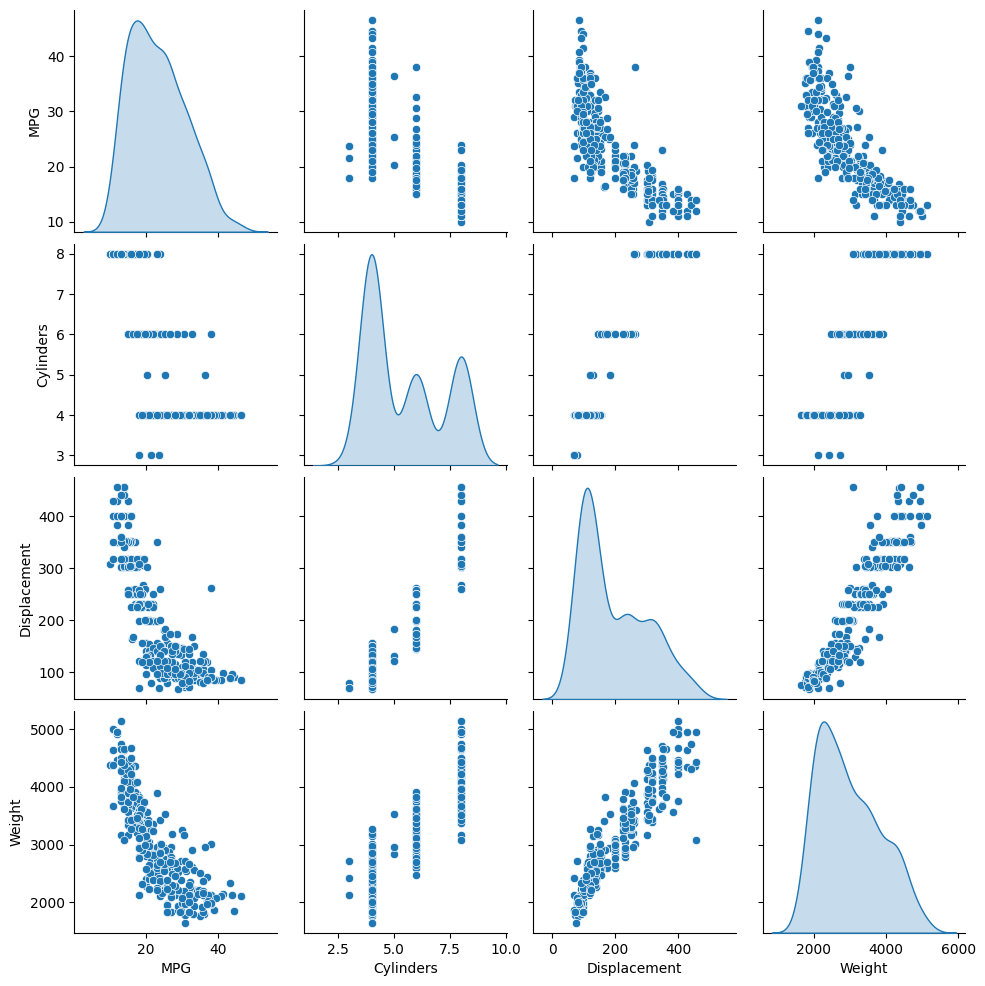

In [11]:
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')

Let's also check the overall statistics. Note how each feature covers a very different range:

In [12]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0


### Split features from labels

Separate the target value—the "label"—from the features. This label is the value that you will train the model to predict.

In [13]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

### Normalization

In the table of statistics it's easy to see how different the ranges of each feature are:

In [14]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
MPG,23.310510,7.728652
Cylinders,5.477707,1.699788
Displacement,195.318471,104.331589
Horsepower,104.869427,38.096214
Weight,2990.251592,843.898596
Acceleration,15.559236,2.789230
Model Year,75.898089,3.675642


It is good practice to normalize features that use different scales and ranges.

One reason this is important is because the features are multiplied by the model weights. So, the scale of the outputs and the scale of the gradients are affected by the scale of the inputs.

Although a model might converge without feature normalization, normalization makes training much more stable.

### The Normalization layer

The <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Normalization">tf.keras.layers.Normalization</a>normalizer = tf.keras.layers.Normalization(axis=-1)
 is a clean and simple way to add feature normalization into your model.

The first step is to create the layer:

In [15]:
normalizer = tf.keras.layers.Normalization(axis=-1)

Then, fit the state of the preprocessing layer to the data by calling <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Normalization#adapt">Normalization.adapt</a>:

In [16]:
normalizer.adapt(np.array(train_features))

2025-03-22 03:18:44.368547: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Calculate the mean and variance, and store them in the layer:

In [17]:
print(normalizer.mean.numpy())

[[   5.478  195.318  104.869 2990.252   15.559   75.898    0.178    0.197
     0.624]]


In [22]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
    print('First example:', first[0])
    print()
    #print('Normalized:', normalizer(first).numpy())
    print('Normalized:', normalizer(first[0][0]))

First example: [4 90.0 75.0 2125.0 14.5 74 False False True]

Normalized: tf.Tensor([[ -0.87  -1.84  -2.65  -3.54  -4.15 -19.59   9.98   9.55   6.97]], shape=(1, 9), dtype=float32)


### Linear regression

Before building a deep neural network model, start with linear regression using one and several variables.
Linear regression with one variable

Begin with a single-variable linear regression to predict <code>'MPG'</code> from <code>'Horsepower'</code>.

Training a model with <a href="https://www.tensorflow.org/api_docs/python/tf/keras"><code>tf.keras</code></a> typically starts by defining the model architecture. Use a <a href="https://www.tensorflow.org/api_docs/python/tf/keras/Sequential"><code>tf.keras.Sequential</code></a> model, which <a href="https://www.tensorflow.org/guide/keras/sequential_model">represents a sequence of steps</a>.

There are two steps in your single-variable linear regression model:

<ul>
    <li>Normalize the <code>'Horsepower'</code> input features using the <code>tf.keras.layers.Normalization</code> preprocessing layer.</li>
    <li>Apply a linear transformation (y = mx + b) to produce 1 output using a linear layer (<a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense"><code>tf.keras.layers.Dense</code></a>).</li>
</ul>
        
The number of inputs can either be set by the <code>input_shape</code> argument, or automatically when the model is run for the first time.

First, create a NumPy array made of the <code>'Horsepower'</code> features. Then, instantiate the <code>tf.keras.layers.Normalization</code> and fit its state to the <code>horsepower</code> data:

In [23]:
horsepower = np.array(train_features['Horsepower'])

horsepower_normalizer = layers.Normalization(input_shape=[1,], axis=None)
horsepower_normalizer.adapt(horsepower)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Build the Keras Sequential model:

In [24]:
horsepower_model = tf.keras.Sequential([
    horsepower_normalizer,
    layers.Dense(units=1)
])

horsepower_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_1 (Normalization) │ (None, 1)              │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5 (24.00 B)

 Trainable params: 2 (8.00 B)

 Non-trainable params: 3 (16.00 B)

This model will predict <code>'MPG'</code> from <code>'Horsepower'</code>.

Run the untrained model on the first 10 'Horsepower' values. The output won't be good, but notice that it has the expected shape of <code>(10, 1):</code>

In [25]:
horsepower_model.predict(horsepower[:10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


array([[-0.202],
       [-0.114],
       [ 0.373],
       [-0.283],
       [-0.256],
       [-0.101],
       [-0.304],
       [-0.256],
       [-0.067],
       [-0.114]], dtype=float32)

Once the model is built, configure the training procedure using the Keras <code><a href="https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile">Model.compile</a></code> method. The most important arguments to compile are the <code>loss</code> and the <code>optimizer</code>, since these define what will be optimized (<code>mean_absolute_error</code>) and how (using the <code><a href="https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam">tf.keras.optimizers.Adam</a></code>).

In [26]:
horsepower_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

Use Keras <code><a href="https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit">Model.fit</a></code> to execute the training for 100 epochs:

In [27]:
%%time
history = horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: user 3.45 s, sys: 238 ms, total: 3.69 s
Wall time: 3.36 s


Visualize the model's training progress using the stats stored in the <code>history</code> object:

In [28]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,3.804546,4.203439,95
96,3.806718,4.206068,96
97,3.806432,4.185214,97
98,3.802373,4.164998,98
99,3.806748,4.150291,99


In [29]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

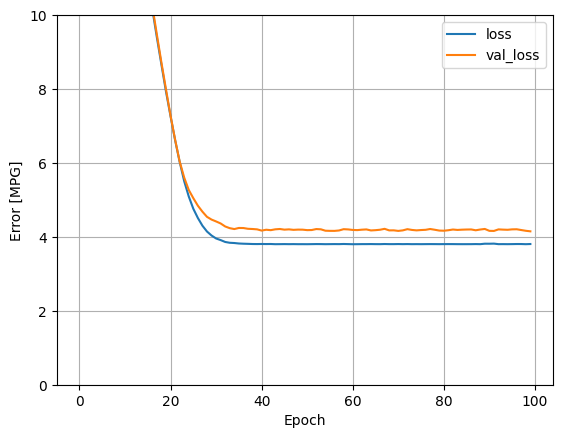

In [30]:
plot_loss(history)

Collect the results on the test set for later:

In [31]:
test_results = {}

test_results['horsepower_model'] = horsepower_model.evaluate(
    test_features['Horsepower'],
    test_labels, verbose=0)

Since this is a single variable regression, it's easy to view the model's predictions as a function of the input:

In [32]:
x = tf.linspace(0.0, 250, 251)
y = horsepower_model.predict(x)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [33]:
def plot_horsepower(x, y):
  plt.scatter(train_features['Horsepower'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Horsepower')
  plt.ylabel('MPG')
  plt.legend()

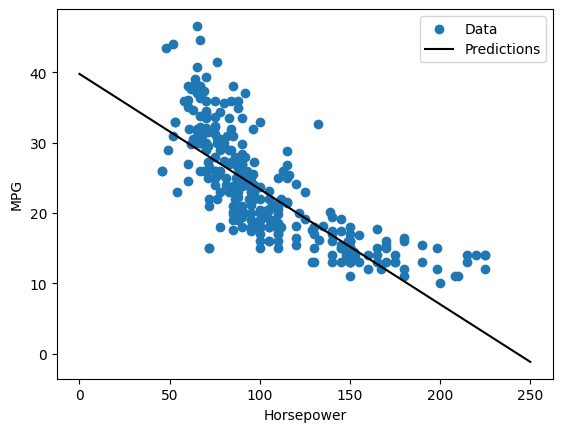

In [34]:
plot_horsepower(x, y)

### Linear regression with multiple inputs

You can use an almost identical setup to make predictions based on multiple inputs. This model still does the same "y = mx + b" except that "m" is a matrix and "x" is a vector.

Create a two-step Keras Sequential model again with the first layer being <code>normalizer</code> (<code>tf.keras.layers.Normalization(axis=-1)</code>) you defined earlier and adapted to the whole dataset:

In [35]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

When you call <code><a href="https://www.tensorflow.org/api_docs/python/tf/keras/Model#predict">Model.predict</a></code> on a batch of inputs, it produces units=1 outputs for each example:

In [36]:
linear_model.predict(train_features[:10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


array([[ 0.062],
       [ 0.218],
       [ 0.49 ],
       [-0.671],
       [-0.103],
       [ 0.305],
       [-0.065],
       [ 0.569],
       [ 0.585],
       [ 0.638]], dtype=float32)

When you call the model, its weight matrices will be built—check that the <code>kernel</code> weights (the m in y = mx + b) have a shape of <code>(9, 1)</code>:

In [37]:
linear_model.layers[1].kernel

<KerasVariable shape=(9, 1), dtype=float32, path=sequential_1/dense_1/kernel>

Configure the model with Keras <code><a href="https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile">Model.compile</a></code> and train with <code><a href="https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit">Model.fit</a></code> for 100 epochs:

In [38]:
linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [39]:
%%time
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: user 3.56 s, sys: 161 ms, total: 3.72 s
Wall time: 3.4 s


Using all the inputs in this regression model achieves a much lower training and validation error than the <code>horsepower_model</code>, which had one input:

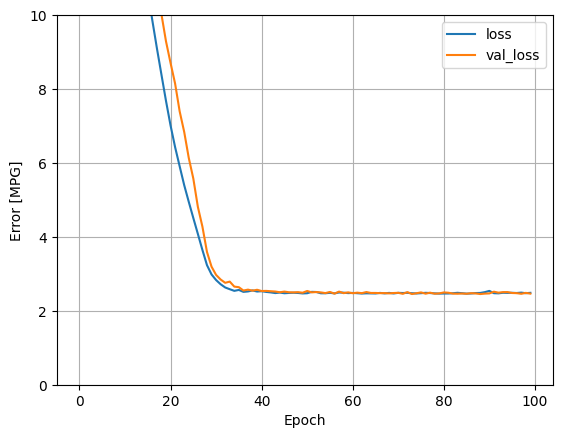

In [40]:
plot_loss(history)

Collect the results on the test set for later:

In [41]:
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

### Regression with a deep neural network (DNN)

In the previous section, you implemented two linear models for single and multiple inputs.

Here, you will implement single-input and multiple-input DNN models.

The code is basically the same except the model is expanded to include some "hidden" non-linear layers. The name "hidden" here just means not directly connected to the inputs or outputs.

These models will contain a few more layers than the linear model:

<ul>
    <li>The normalization layer, as before (with <code>horsepower_normalizer</code> for a single-input model and <code>normalizer</code> for a multiple-input model).</li>
    <li>Two hidden, non-linear, <code>Dense</code>layers with the ReLU (<code>relu</code>) activation function nonlinearity.</li>
    <li>A linear <code>Dense</code> single-output layer.</li>
</ul>

Both models will use the same training procedure, so the <code>compile</code> method is included in the <code>build_and_compile_model</code> function below.

In [42]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

### Regression using a DNN and a single input

Create a DNN model with only <code>'Horsepower'</code> as input and <code>horsepower_normalizer</code> (defined earlier) as the normalization layer:

In [43]:
dnn_horsepower_model = build_and_compile_model(horsepower_normalizer)

This model has quite a few more trainable parameters than the linear models:

In [44]:
dnn_horsepower_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_1 (Normalization) │ (None, 1)              │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,356 (17.02 KB)

 Trainable params: 4,353 (17.00 KB)

 Non-trainable params: 3 (16.00 B)

Train the model with Keras <code><a href="https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit">Model.fit</a></code>:

In [45]:
%%time
history = dnn_horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 4.13 s, sys: 267 ms, total: 4.39 s
Wall time: 3.93 s


This model does slightly better than the linear single-input <code>horsepower_model</code>:

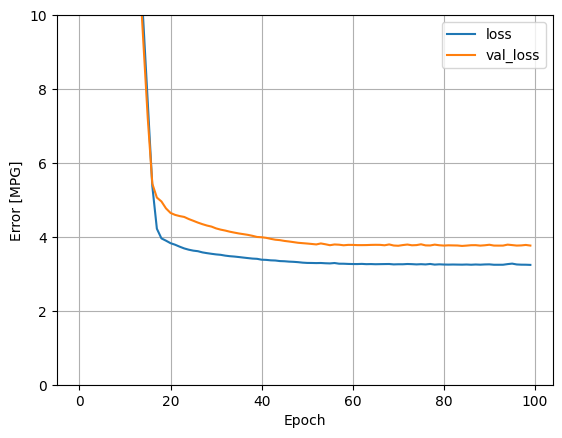

In [46]:
plot_loss(history)

If you plot the predictions as a function of <code>'Horsepower'</code>, you should notice how this model takes advantage of the nonlinearity provided by the hidden layers:

In [47]:
x = tf.linspace(0.0, 250, 251)
y = dnn_horsepower_model.predict(x)

1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/stepWARNING:tensorflow:5 out of the last 17 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x7f59f42449a0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


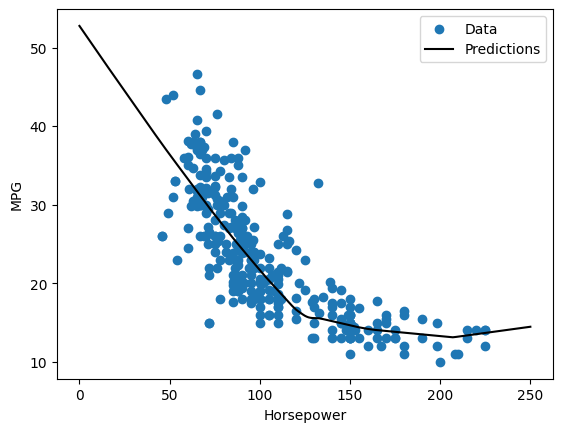

In [48]:
plot_horsepower(x, y)

Collect the results on the test set for later:

In [49]:
test_results['dnn_horsepower_model'] = dnn_horsepower_model.evaluate(
    test_features['Horsepower'], test_labels,
    verbose=0)

### Regression using a DNN and multiple inputs

Repeat the previous process using all the inputs. The model's performance slightly improves on the validation dataset.

In [50]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (10, 9)                │            19 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19 (80.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 19 (80.00 B)

In [51]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 4.29 s, sys: 283 ms, total: 4.57 s
Wall time: 4.07 s


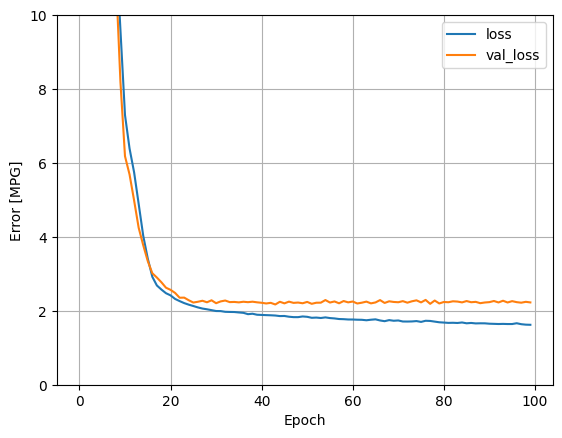

In [52]:
plot_loss(history)

Collect the results on the test set:

In [53]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

### Performance

Since all models have been trained, you can review their test set performance:

In [54]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.651438
linear_model,2.451200
dnn_horsepower_model,2.911988
dnn_model,1.750570


These results match the validation error observed during training.

### Make predictions

You can now make predictions with the <code>dnn_model</code> on the test set using Keras <code><a href="https://www.tensorflow.org/api_docs/python/tf/keras/Model#predict">Model.predict</a></code> and review the loss:

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


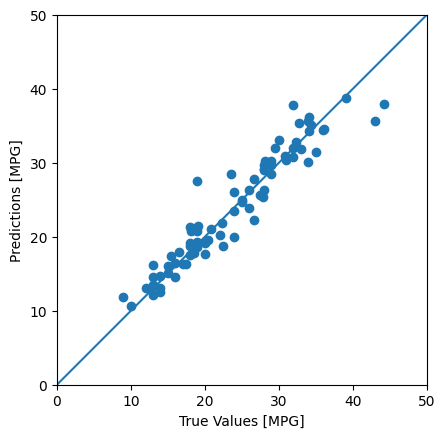

In [55]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

It appears that the model predicts reasonably well.

Now, check the error distribution:

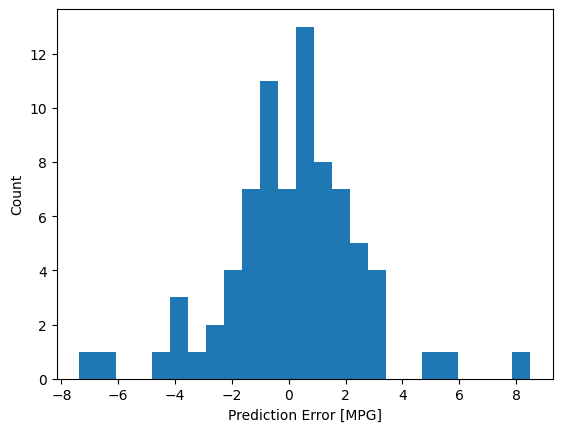

In [56]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')

If you're happy with the model, save it for later use with <code><a href="https://www.tensorflow.org/api_docs/python/tf/keras/Model#save">Model.save</a></code>:

In [57]:
dnn_model.save('dnn_model.keras')

If you reload the model, it gives identical output:

In [58]:
reloaded = tf.keras.models.load_model('dnn_model.keras')

test_results['reloaded'] = reloaded.evaluate(
    test_features, test_labels, verbose=0)

In [59]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.651438
linear_model,2.451200
dnn_horsepower_model,2.911988
dnn_model,1.750570
reloaded,1.750570


## Conclusion

This notebook introduced a few techniques to handle a regression problem. Here are a few more tips that may help:

<ul>
    <li>Mean squared error (MSE) (<code><a href="https://www.tensorflow.org/api_docs/python/tf/keras/losses/MeanSquaredError">tf.keras.losses.MeanSquaredError</a></code>) and mean absolute error (MAE) (<code><a href="https://www.tensorflow.org/api_docs/python/tf/keras/losses/MeanAbsoluteError">tf.keras.losses.MeanAbsoluteError</a></code>) are common loss functions used for regression problems. MAE is less sensitive to outliers. Different loss functions are used for classification problems.</li>
    <li>Similarly, evaluation metrics used for regression differ from classification.</li>
    <li>When numeric input data features have values with different ranges, each feature should be scaled independently to the same range.</li>
    <li>Overfitting is a common problem for DNN models, though it wasn't a problem for this tutorial. Visit the <a href="https://www.tensorflow.org/tutorials/keras/overfit_and_underfit">Overfit and underfit</a> tutorial for more help with this.</li>
</ul>